In [23]:
import jsonlines
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from code.fasttext.embedding_utils import TableEncoder, compare_embeddings
from code.global_matching_strategies import stable_marriage

# Working on the Subset (the same used for a subpart of SLOTH)

In [2]:
sloth_tested_pairs = pd.read_csv(
    '/home/giovanni/unimore/TESI/src/data/train_set_turl_malaguti.csv',
    nrows=1000
    )
sloth_tested_pairs

,r_id,s_id,jsim,o_a,a%
0,857959-5,956801-5,1.000000,6,1.000000
1,14763133-1,15182906-1,0.827586,38,0.826087
2,15182906-1,33954290-1,0.787879,32,0.615385
3,14772277-1,32928438-1,0.900000,36,0.692308
4,31534804-2,32612781-1,0.300000,8,0.111111
...,...,...,...,...,...
995,27340139-4,33030049-4,1.000000,21,1.000000
996,31200308-1,31802539-1,0.666667,4,0.666667
997,15181195-1,32928401-1,0.900000,48,0.960000
998,34374076-1,6755735-3,0.500000,40,0.208333


In [140]:
wikitables = {}
with jsonlines.open('/home/giovanni/unimore/TESI/src/data/small_train_tables.jsonl', 'r') as reader:
    for obj in reader:
        wikitables[obj['_id']] = obj

In [141]:
def rebuild_table(id):
    df = pd.DataFrame(columns=wikitables[id]['tableHeaders'][0])
    for entry in wikitables[id]['tableData']:
        row = [entry_data['text'] for entry_data in entry]
        df.loc[len(df)] = row
    return df

In [210]:
sloth_tested_pairs.sort_values(by='o_a', ascending=False)

,r_id,s_id,jsim,o_a,a%
303,35289787-1,35289993-1,1.000000,242,1.000000
234,39176684-1,39709896-5,1.000000,240,1.000000
393,32111627-5,32490382-2,1.000000,209,1.000000
917,37967403-2,38908559-3,1.000000,198,1.000000
535,39801410-4,39801931-4,1.000000,192,1.000000
...,...,...,...,...,...
758,1107252-1,2482815-1,0.428571,2,0.333333
958,133238-1,2797861-1,0.571429,2,0.333333
419,14235122-1,5773951-1,0.384615,2,0.166667
449,31485938-3,8227798-1,0.168539,2,0.037037


In [245]:
idx = 103
r_id, s_id = sloth_tested_pairs.loc[idx, ['r_id', 's_id']]
r_table, s_table = rebuild_table(r_id), rebuild_table(s_id)
wikitables[r_id]['pgTitle'], wikitables[s_id]['pgTitle']

('1980 Intertoto Cup', '1994–95 UEFA Champions League group stage')

In [246]:
r_table

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1,Nitra,6,4,0,2,9,3,+6,8
1,2,LASK Linz,6,2,2,2,7,9,−2,6
2,3,Esbjerg,6,2,1,3,8,7,+1,5
3,4,Polonia Bytom,6,2,1,3,4,9,−5,5


In [247]:
s_table

,Team,Pld,W,D,L,GF,GA,GD,Pts
0,Benfica,6,3,3,0,9,5,+4,9
1,Hajduk Split,6,2,2,2,5,7,−2,6
2,Steaua Bucureşti,6,1,3,2,7,6,+1,5
3,Anderlecht,6,0,4,2,4,7,−3,4


In [213]:
r_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 21
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Pos                         22 non-null     object
 1   Team [[| v ]][[| t ]][ e ]  22 non-null     object
 2   Pld                         22 non-null     object
 3   W                           22 non-null     object
 4   D                           22 non-null     object
 5   L                           22 non-null     object
 6   GF                          22 non-null     object
 7   GA                          22 non-null     object
 8   GD                          22 non-null     object
 9   Pts                         22 non-null     object
 10  Promotion or relegation     22 non-null     object
dtypes: object(11)
memory usage: 2.1+ KB


In [214]:
s_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 21
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Pos                         22 non-null     object
 1   Team [[| v ]][[| t ]][ e ]  22 non-null     object
 2   Pld                         22 non-null     object
 3   W                           22 non-null     object
 4   D                           22 non-null     object
 5   L                           22 non-null     object
 6   GF                          22 non-null     object
 7   GA                          22 non-null     object
 8   GD                          22 non-null     object
 9   Pts                         22 non-null     object
 10  Promotion or relegation     22 non-null     object
dtypes: object(11)
memory usage: 2.1+ KB


In [199]:
# In case a dataframe has two or more columns with the same name
for i, c in enumerate(r_table.columns):
    if c in r_table.columns.delete(i):
        r_table.columns.values[i] = f"{r_table.columns[i]}_{i}"
r_table.head()

,Characteristic,Phenotype
0,Homozygote viability,Normal
1,Fertility,Normal
2,Body weight,Normal
3,Anxiety,Normal
4,Neurological assessment,Normal


In [217]:
tabenc = TableEncoder()
options = ['cosine similarity', 'cosine similarity-wlabel', 'cosine similarity-nonum', 'cosine similarity-wlabel-nonum']

In [218]:
add_label = [False, True]
remove_numbers = [False, True]

col_comp_emb = compare_embeddings(r_table, s_table, tabenc, add_label=add_label, remove_numbers=remove_numbers, on='columns')
row_comp_emb = compare_embeddings(r_table, s_table, tabenc, add_label=add_label, remove_numbers=remove_numbers, on='rows')

In [219]:
stat_col, stat_row  = pd.DataFrame(), pd.DataFrame()
for opt in options:
    stat_col[opt] = stable_marriage(col_comp_emb[['C1', 'C2', opt]], ['C1', 'C2', opt]).iloc[:, -1].fillna(0)
    stat_row[opt] = stable_marriage(row_comp_emb[['R1', 'R2', opt]], ['R1', 'R2', opt]).iloc[:, -1].fillna(0)

In [220]:
stat_col

,cosine similarity,cosine similarity-wlabel,cosine similarity-nonum,cosine similarity-wlabel-nonum
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,0.0,1.0
3,1.0,1.0,0.0,1.0
4,1.0,1.0,0.0,0.0
5,1.0,1.0,0.0,0.0
6,1.0,1.0,0.0,0.0
7,1.0,1.0,0.0,0.0
8,1.0,1.0,0.0,0.0
9,1.0,1.0,0.0,0.0


In [221]:
stat_row

,cosine similarity,cosine similarity-wlabel,cosine similarity-nonum,cosine similarity-wlabel-nonum
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0


In [222]:
stat_col.describe()

,cosine similarity,cosine similarity-wlabel,cosine similarity-nonum,cosine similarity-wlabel-nonum
count,1.100000e+01,1.100000e+01,11.000000,11.000000
mean,1.000000e+00,1.000000e+00,0.181818,0.363636
std,1.447554e-16,1.570092e-16,0.404520,0.504525
min,1.000000e+00,1.000000e+00,0.000000,0.000000
25%,1.000000e+00,1.000000e+00,0.000000,0.000000
50%,1.000000e+00,1.000000e+00,0.000000,0.000000
75%,1.000000e+00,1.000000e+00,0.000000,1.000000
max,1.000000e+00,1.000000e+00,1.000000,1.000000


In [224]:
stat_row.describe()

,cosine similarity,cosine similarity-wlabel,cosine similarity-nonum,cosine similarity-wlabel-nonum
count,2.200000e+01,2.200000e+01,22.000000,2.200000e+01
mean,1.000000e+00,1.000000e+00,0.863636,1.000000e+00
std,1.235342e-16,9.989070e-17,0.351250,1.186878e-16
min,1.000000e+00,1.000000e+00,0.000000,1.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
50%,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000,1.000000e+00


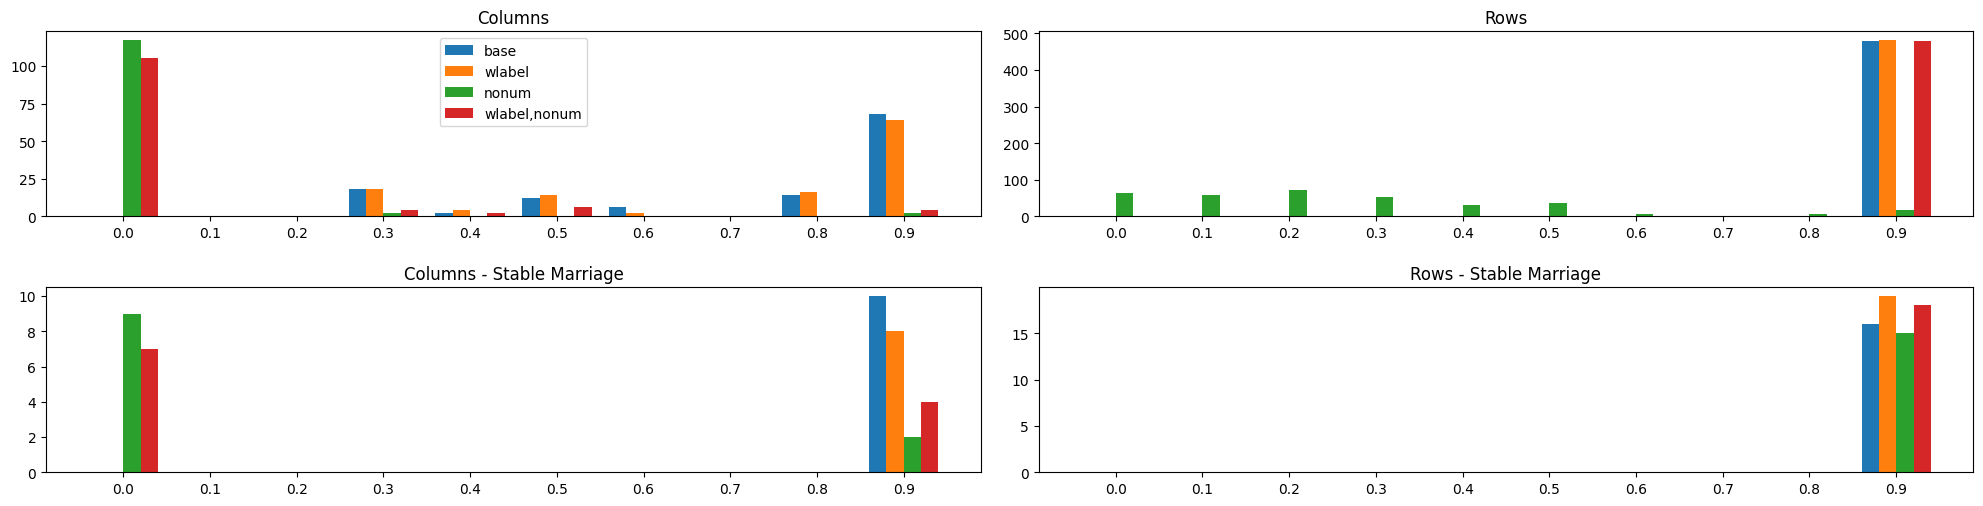

In [225]:
bins=np.arange(0, 1.1, 0.1)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 5))
fig.tight_layout(h_pad=3)

for title, ax, data, headers in zip((('Columns', 'Columns - Stable Marriage'), ('Rows', 'Rows - Stable Marriage')), ((ax0, ax2), (ax1, ax3)), (col_comp_emb.fillna(0), row_comp_emb), (['C1', 'C2'], ['R1', 'R2'])):
    ax_up, ax_down = ax
    ax_up.set_title(title[0]), ax_down.set_title(title[1])
    ax_up.set_xticks(bins), ax_down.set_xticks(bins)
    ax_up.hist(            
        [data[opt] for opt in options],
        bins=bins,        
        #density=True,
        align='left',
        label=['base', 'wlabel', 'nonum', 'wlabel,nonum']
    )
    ax_down.hist(
        [
            stable_marriage(data[headers + [opt]], columns=headers + [opt]).fillna(np.nan).iloc[:, -1]
            for opt in options  
        ],
        bins=bins,
        align='left',
        label=['base', 'wlabel', 'nonum', 'wlabel,nonum'],
        #density=True
    )
    #ax_up.legend(loc='upper left'), ax_down.legend(loc='upper left')
ax0.legend()